<a href="https://colab.research.google.com/github/jeffkblee/Image-Processing/blob/main/Jeffrey.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install git+https://github.com/DODAS-TS/boto3sts
!pip install 'https://github.com/CYGNUS-RD/middleware/blob/master/midas/midaslib.tar.gz?raw=true'
!pip install git+https://github.com/CYGNUS-RD/cygno.git -U

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/DODAS-TS/boto3sts to /tmp/pip-req-build-8xczrks4
  Running command git clone -q https://github.com/DODAS-TS/boto3sts /tmp/pip-req-build-8xczrks4
     |████████████████████████████████| 132 kB 9.1 MB/s 
     |████████████████████████████████| 8.9 MB 19.4 MB/s 
     |████████████████████████████████| 79 kB 4.3 MB/s 
     |████████████████████████████████| 138 kB 36.0 MB/s 
     |████████████████████████████████| 856 kB 37.6 MB/s 
     |████████████████████████████████| 127 kB 33.2 MB/s 
  Created wheel for boto3sts: filename=boto3sts-0.0.8-py3-none-any.whl size=4677 sha256=7dcf4a7b2f660004115cd0bb756af7db1496b8bb73e74df0fbd01038233c76e7
  Stored in directory: /tmp/pip-ephem-wheel-cache-9711clk1/wheels/d6/0e/a8/204df23fe4a288550d10cf9cf744ab143484e177e12982e424
Successfully built boto3sts
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.

https://s3.cloud.infn.it/v1/AUTH_2ebf769785574195bde2ff418deac08a/cygno-data/STD/run01403.mid.gz
https://s3.cloud.infn.it/v1/AUTH_2ebf769785574195bde2ff418deac08a/cygno-data/STD/run01403.mid.gz
Saw a special event
Event # 0 of type ID 3 contains banks DMND, MSRD, CRNT, STAT, TPTR
Received event with timestamp 1655212351 containing banks DMND, MSRD, CRNT, STAT, TPTR
2022-06-14 13:12:31, banks DMND, MSRD, CRNT, STAT, TPTR
Event # 0 of type ID 4 contains banks DMND, MSRD, CRNT, STAT, TPTR
Received event with timestamp 1655212351 containing banks DMND, MSRD, CRNT, STAT, TPTR
2022-06-14 13:12:31, banks DMND, MSRD, CRNT, STAT, TPTR
Event # 0 of type ID 6 contains banks DMND, MSRD
Received event with timestamp 1655212351 containing banks DMND, MSRD
2022-06-14 13:12:31, banks DMND, MSRD
Event # 0 of type ID 1 contains banks CAM0
Received event with timestamp 1655212352 containing banks CAM0
2022-06-14 13:12:32, banks CAM0


file /tmp/run01403.mid.gz cached

Event # 1 of type ID 1 contains banks CAM0
Received event with timestamp 1655212353 containing banks CAM0
2022-06-14 13:12:33, banks CAM0
Event # 2 of type ID 1 contains banks CAM0
Received event with timestamp 1655212354 containing banks CAM0
2022-06-14 13:12:34, banks CAM0
Event # 3 of type ID 1 contains banks CAM0
Received event with timestamp 1655212354 containing banks CAM0
2022-06-14 13:12:34, banks CAM0


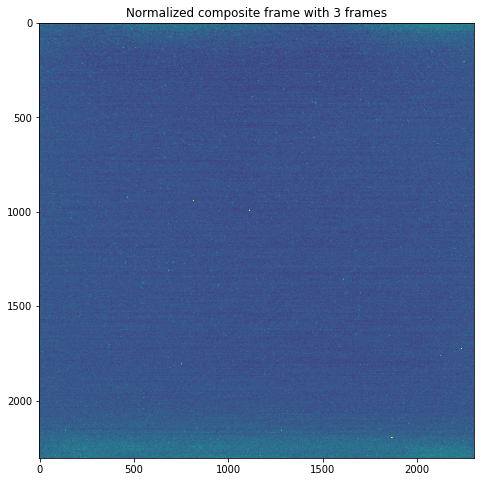

Commit


In [3]:
# Reads images from an array and combines them.
# Generate a normalized composite image.
# Input: run number, path
# Output: normalized composite image, number of frames used to generate said image.
# Note: Needs manual checking of shape of array to set up "image" variable.

import midas.file_reader
from datetime import datetime
import numpy as np
from matplotlib import pyplot as plt
import cygno as cy\


def ped_array(run_, path_ = '/tmp/', cloud_ = True, tag_ = 'STD', verbose_ = True):

    mfile = cy.open_mid(run=run_, path=path_, cloud=cloud_, tag=tag_, verbose=verbose_)

    fileoutm = (path_+"mean_Run{:05d}".format(run_))

    i = 0
    #shape of the images array (23004,2304)
    m_image = np.zeros((2304,2304)) # average value of frames
    s_image = np.zeros((2304,2304)) # root mean square of frames
    for event in mfile:
        if event.header.is_midas_internal_event():
            print("Saw a special event")
            continue

        bank_names = ", ".join(b.name for b in event.banks.values())
        print("Event # %s of type ID %s contains banks %s" % (event.header.serial_number, event.header.event_id, bank_names))
        print("Received event with timestamp %s containing banks %s" % (event.header.timestamp, bank_names))
        print("%s, banks %s" % (datetime.utcfromtimestamp(event.header.timestamp).strftime('%Y-%m-%d %H:%M:%S'), bank_names))

        if i >= 3: break # Limit the frames produced for ease of debugging
        for bank_name, bank in event.banks.items():
            if bank_name=='DGH0': # PMTs wavform 
                header = cy.daq_dgz2header(bank)
                print (header)
                waveform = cy.daq_dgz2array(event.banks['DIG0'], header)
            if bank_name=='CAM0': # CAM image
                imageFrame, _, _ = cy.daq_cam2array(bank)
                m_image = np.add(m_image, imageFrame)
                # plt.figure(figsize=(8,8))
                # plt.imshow(imageFrame, vmin=95, vmax=115)
                # plt.title("Frame %s" %i)
                # plt.show()
                i += 1
            if bank_name=='INPT': # SLOW channels array
                slow = cy.daq_slow2array(bank)

    m_image = m_image/i

    return m_image, i

pedestal, noFrame = ped_array(1403)
plt.figure(figsize=(8,8))
plt.imshow(pedestal, vmin=95, vmax=115)
plt.title("Normalized composite frame with %s frames" %noFrame)
plt.show()